In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt





In [4]:
train = pd.read_csv('data/datasets/ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)


train.head()

test = pd.read_csv('data/datasets/ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('data/datasets/vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('data/datasets/ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [5]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)

vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)

In [6]:
vessels.head()

,shippingLineId,vesselId,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,homePort,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt
0,0,599.0,6500,21200.0,58684,17606.0,83.0,32.0,22.20,NaN,0.0,NaN,NaN,OSLO,199.00,5.0,18.6,15.2,150.0,2000
1,1,65.0,4902,12325.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,MONROVIA,182.00,NaN,NaN,NaN,NaN,2006
2,2,640.0,5000,13059.0,46800,NaN,83.0,31.0,NaN,NaN,14220.0,NaN,NaN,SAINT JOHN'S,182.00,NaN,NaN,NaN,NaN,2010
3,3,255.0,4200,12588.0,39362,NaN,83.0,28.0,NaN,NaN,11060.0,NaN,NaN,NaN,167.00,NaN,NaN,NaN,NaN,2011
4,4,68.0,7450,21052.0,75528,24391.0,83.0,37.2,22.23,NaN,13140.0,491.47,3236.78,Panama,199.98,NaN,NaN,NaN,NaN,2018


In [7]:


train = train.merge(ports[['portId', 'latitude', 'longitude']], how='left', left_on='portId', right_on='portId', suffixes=('', '_port'))
train.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000


In [8]:
train = train.merge(vessels[['vesselId', 'length', 'shippingLineId', 'maxSpeed', 'breadth', 'DWT']], on='vesselId', how='left')
train['vessel_deep_sea'] = np.where(train['length'] > 200, 1, 0)

num_maxSpeed_nan = train['breadth'].isna().sum()
print(f"Number of NaN values in maxSpeed: {num_maxSpeed_nan}")
train.head()

Number of NaN values in maxSpeed: 14949


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,latitude_port,longitude_port,length,shippingLineId,maxSpeed,breadth,DWT,vessel_deep_sea
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,0,0,-33.5875,-71.618889,199.00,9,NaN,32.00,21214.0,0
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,1,1,8.9670,-79.533000,199.97,6,22.5,32.26,18878.0,0
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,2,2,39.2325,-76.558889,199.00,14,NaN,32.00,18383.0,0
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,3,3,-34.4625,150.899444,199.00,5,NaN,32.00,15199.0,0
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,4,4,35.7830,-5.817000,199.95,6,22.4,32.20,18833.0,0


In [9]:

def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    window_size_days = 5
    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        for start_idx in range(len(unique_dates) - window_size_days + 1):
            start_date = unique_dates[start_idx]
            end_date = unique_dates[start_idx + window_size_days - 1]
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # Skip empty windows
            if len(window) == 0:
                continue

            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'cog_sin': row['cog_sin'],
                    'cog_cos': row['cog_cos'],
                    'sog': row['sog'],
                    'rot': row['rot'],
                    'under_way': row['under_way'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_sin_first': reference_row['cog_sin'],
                    'cog_cos_first': reference_row['cog_cos'],
                    'sog_first': reference_row['sog'],
                    'rot_first': reference_row['rot'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

    return pd.DataFrame(windows)

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371  # Radius of Earth in kilometers
    return r * c  # Distance in kilometers

### Feature engineering 

In [ ]:
def feature_engineering(train):
    train = train.copy()
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # # Handle NaNs
    # train[['latitude', 'longitude', 'cog', 'time']] = (
    #     train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    # ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time'] 
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['rot'] = train['rot']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    features['cog_rad'] = np.radians(features['cog'])
    features['cog_sin'] = np.sin(features['cog_rad'])
    features['cog_cos'] = np.cos(features['cog_rad'])

    # Additional angle transformations
   

    # Calculate area covered within the time window
    features = create_five_day_windows(features)

 
    # Additional time-based features
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute
    features['day_of_week'] = features['time'].dt.dayofweek

    return features

train_features = feature_engineering(train)

In [ ]:
nan_values = train_features.isnull().sum()
print(nan_values)


# Drop the columns 'time' and 'rot'
train_features = train_features.drop(columns=['time', 'rot_first'])

In [13]:
train_features.head()

,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,DWT,under_way,speed,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,2024-02-05 21:16:16,32.53669,-117.46805,32.684444,-117.161389,248.7,21214.0,1,1.141108e-04,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,2024-02-05 21:36:47,32.53490,-117.47044,32.684444,-117.161389,41.9,21214.0,1,3.367175e-08,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,2024-02-05 21:57:04,32.54160,-117.46490,32.684444,-117.161389,21.9,21214.0,1,1.275335e-04,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,2024-02-05 22:17:14,32.54949,-117.46049,32.684444,-117.161389,19.2,21214.0,1,0.000000e+00,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,2024-02-05 22:38:00,32.55780,-117.45671,32.684444,-117.161389,21.6,21214.0,1,3.274905e-08,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [14]:
def find_last_features(features):
    # Assuming that the last row for every vesselId is the most recent
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
last_features.head()


,vesselId,time,latitude,longitude,latitude_port,longitude_port,cog,DWT,under_way,speed,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
0,0,2024-05-01 12:41:57,34.57936,128.99926,35.109444,129.059444,221.5,21214.0,1,7.306813e-05,...,5,1,12,41,3.865904,-0.662620,-0.748956,0,9,199.00
1,1,2024-04-30 10:12:01,1.24460,103.39997,51.498889,-2.712222,305.1,18878.0,1,2.141556e-07,...,4,30,10,12,5.325000,-0.818150,0.575005,0,6,199.97
2,2,2024-05-07 23:59:02,18.13873,-69.74863,18.475278,-69.881111,176.0,18383.0,1,7.936508e-09,...,5,7,23,59,3.071779,0.069756,-0.997564,0,14,199.00
3,3,2024-04-26 13:29:25,41.64055,143.29942,42.988611,144.353611,87.6,15199.0,1,1.419615e-05,...,4,26,13,29,1.528908,0.999123,0.041876,0,5,199.00
4,4,2024-05-07 12:28:39,26.58710,121.27831,27.583000,120.450000,39.1,18833.0,1,7.976980e-05,...,5,7,12,28,0.682424,0.630676,0.776046,0,6,199.95


### Train the model

In [15]:
# # Define features and target
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=['latitude', 'longitude']) 
X.head()

,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,32.684444,-117.161389,21214.0,1,1.141108e-04,0.000056,5.574396e-05,6.0,1216.0,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,32.684444,-117.161389,21214.0,1,3.367175e-08,0.000044,1.869911e-05,6.0,1231.0,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,32.684444,-117.161389,21214.0,1,1.275335e-04,0.000065,7.514916e-05,6.0,1217.0,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,32.684444,-117.161389,21214.0,1,0.000000e+00,0.000059,5.648372e-05,6.0,1210.0,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,32.684444,-117.161389,21214.0,1,3.274905e-08,0.000040,3.321040e-08,6.0,1246.0,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [16]:
# model = RandomForestRegressor(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 300],            # Number of trees in the forest
    'max_depth': [5, 7, 10, None],             # Maximum depth of the tree
    'min_samples_split': [2, 5],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],            # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],      # The number of features to consider when looking for the best split
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=20, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42)
random_search.fit(X, y)

best_model = random_search.best_estimator_

# Output the best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (negative mean squared error): {-random_search.best_score_}")


NameError: name 'param_grid' is not defined

In [17]:
X.head()

,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,month,day,hour,minute,cog_rad,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length
412804,0,32.684444,-117.161389,21214.0,1,1.141108e-04,0.000056,5.574396e-05,6.0,1216.0,...,2,5,21,16,4.340634,-0.931691,-0.363251,0,9,199.0
412959,0,32.684444,-117.161389,21214.0,1,3.367175e-08,0.000044,1.869911e-05,6.0,1231.0,...,2,5,21,36,0.731293,0.667833,0.744312,0,9,199.0
413174,0,32.684444,-117.161389,21214.0,1,1.275335e-04,0.000065,7.514916e-05,6.0,1217.0,...,2,5,21,57,0.382227,0.372988,0.927836,0,9,199.0
413305,0,32.684444,-117.161389,21214.0,1,0.000000e+00,0.000059,5.648372e-05,6.0,1210.0,...,2,5,22,17,0.335103,0.328867,0.944376,0,9,199.0
413498,0,32.684444,-117.161389,21214.0,1,3.274905e-08,0.000040,3.321040e-08,6.0,1246.0,...,2,5,22,38,0.376991,0.368125,0.929776,0,9,199.0


In [18]:
print(X.keys())
'''
['vesselId', 'cog', 'sog', 'under_way', 'latitude_first',
       'longitude_first', 'cog_first', 'sog_first', 'under_way_first',
       'time_since_start', 'month', 'day', 'hour', 'minute']
'''

### Prepare test data for predictions
def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the refrence row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_sin_first'] = prepared_test['cog_sin']
    prepared_test['cog_cos_first'] = prepared_test['cog_sin']
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute and second columns
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute
    # prepared_test['second'] = test['time'].dt.second

    prepared_test.drop('time', axis=1, inplace=True)
    prepared_test.drop('time_last', axis=1, inplace=True)
    prepared_test.drop('year', axis=1, inplace=True)

    # Reorder the columns
    prepared_test = prepared_test[['vesselId', 'cog_sin', 'cog_cos', 'sog', 'under_way',
                                   'latitude_first', 'longitude_first', 'cog_sin_first', 'cog_cos_first', 'sog_first',
                                     'under_way_first', 'time_since_start', 'month', 'day',
                                   'hour', 'minute']]

    return prepared_test

test_df = prepare_test_for_predictions(test, last_features)
print(test_df.head())
print(test_df.shape)

Index(['vesselId', 'time', 'time_last', 'latitude', 'longitude',
       'latitude_port', 'longitude_port', 'cog', 'DWT', 'under_way', 'speed',
       'rolling_speed_mean', 'rolling_speed_median', 'rolling_movement_count',
       'time_since_last_movement', 'latitude_1', 'longitude_1', 'time_1',
       'latitude_2', 'longitude_2', 'time_2', 'latitude_3', 'longitude_3',
       'time_3', 'time_since_day_1', 'latitude_day_1', 'longitude_day_1',
       'time_since_day_2', 'latitude_day_2', 'longitude_day_2',
       'time_since_day_3', 'latitude_day_3', 'longitude_day_3',
       'time_since_day_4', 'latitude_day_4', 'longitude_day_4',
       'time_since_day_5', 'latitude_day_5', 'longitude_day_5', 'cog_rad',
       'cog_sin', 'cog_cos', 'vessel_deep_sea', 'shippingLineId', 'length'],
      dtype='object')


,vesselId,latitude_port,longitude_port,DWT,under_way,speed,rolling_speed_mean,rolling_speed_median,rolling_movement_count,time_since_last_movement,...,cog_sin,cog_cos,vessel_deep_sea,shippingLineId,length,month,day,hour,minute,speed_last_2_hours
0,412,31.140556,-81.496667,31143.0,0.0,1.832843e-08,0.000005,5.241870e-08,0.0,1256.0,...,-0.662620,-0.748956,1.0,5.0,230.0,5,8,0,3,0.0
1,373,14.808333,120.279444,13238.0,0.0,7.804535e-05,0.000021,3.058126e-08,0.0,1762.0,...,-0.818150,0.575005,0.0,3.0,124.0,5,8,0,6,0.0
2,181,42.098889,11.780833,7150.0,1.0,8.407760e-05,0.000036,1.188834e-05,3.0,1506.0,...,0.069756,-0.997564,0.0,11.0,186.0,5,8,0,10,0.0
3,8,-43.606111,172.716111,13951.0,0.0,7.233601e-05,0.000025,5.377673e-08,0.0,900.0,...,0.999123,0.041876,0.0,6.0,183.0,5,8,0,10,0.0
4,65,48.380556,-4.474167,12325.0,0.0,5.734694e-05,0.000030,1.613756e-07,3.0,1973.0,...,0.630676,0.776046,0.0,1.0,182.0,5,8,0,12,0.0


Filtered vessel data:
     longitude_day_1  latitude_day_1  longitude_day_2  latitude_day_2  \
0          -81.49792        31.14647        -81.08598        30.93523   
143        -81.49792        31.14647        -81.08598        30.93523   
282        -81.49792        31.14647        -81.08598        30.93523   
426        -81.49792        31.14647        -81.08598        30.93523   
551        -81.49792        31.14647        -81.08598        30.93523   

     longitude_day_3  latitude_day_3  longitude_day_4  latitude_day_4  \
0          -81.08664        30.93475        -81.08634        30.93497   
143        -81.08664        30.93475        -81.08634        30.93497   
282        -81.08664        30.93475        -81.08634        30.93497   
426        -81.08664        30.93475        -81.08634        30.93497   
551        -81.08664        30.93475        -81.08634        30.93497   

     longitude_day_5  latitude_day_5  
0           -81.0867         30.9347  
143         -81.0867  

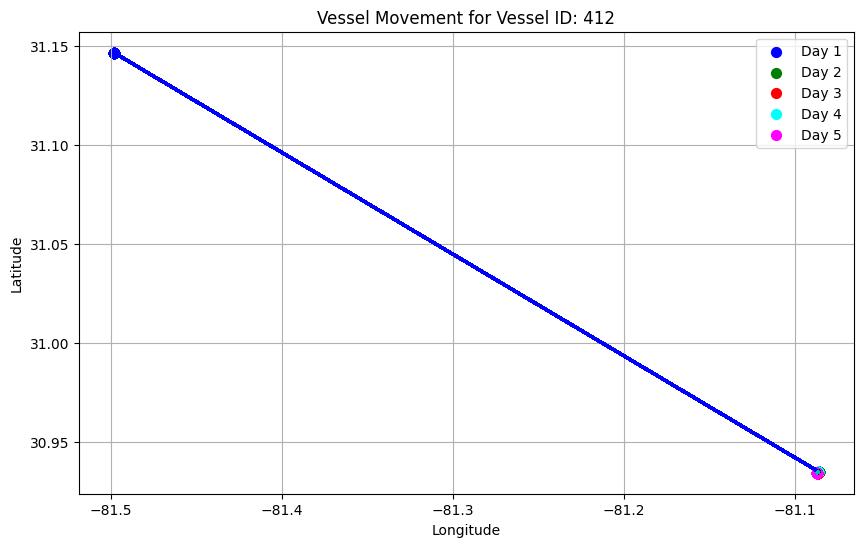

In [19]:
predictions = best_model.predict(test_df)
print(predictions)
print(predictions.shape)

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('predictions_ing_wfix.csv', index=False)

In [1]:
merged_df = pd.merge(test, predictions_df, on='ID', how='left')
merged_df.drop(['ID', 'scaling_factor'])
merged_df.head()

NameError: name 'pd' is not defined

In [23]:
predictions_df.to_csv('data/submissions/predictions_2_5d_vm.csv', index=False)

In [ ]:
merged_df.to_csv('data/test/plotting_boats.csv')